# Appendix C:  True signal and FDR threshold adaptability


This Appendix explores concepts associated with 'true signal' and how the FDR threshold adapts to different types of true signal. Let's first import the necessary packages.

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot
import spm1d    #https://github.com/0todd0000/spm1d
import power1d  #https://github.com/0todd0000/power1d
import fdr1d    #https://github.com/0todd0000/fdr1d

___

### True signal model

Next let's define use a Gaussian pulse as our (arbitrary) true signal:

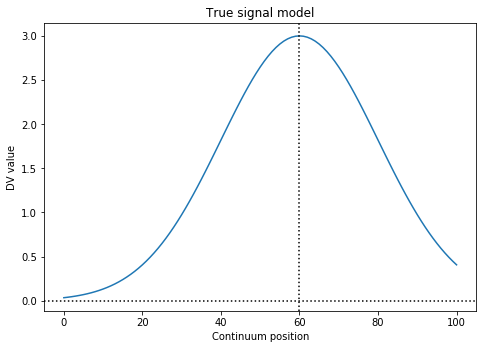

In [2]:
Q       = 101  #number of continuum nodes
q       = 60   #center of Gaussian pulse
sigma   = 20   #standard deviation of the pulse
amp     = 3.0  #amplitude of the pulse
signal  = power1d.geom.GaussianPulse(Q=Q, q=q, sigma=sigma, amp=amp).toarray()


pyplot.figure()
ax      = pyplot.axes( [0, 0, 1, 1] )
ax.plot( signal )
ax.axhline(0, color='k', ls=':')
ax.axvline(q, color='k', ls=':')
ax.set_xlabel('Continuum position')
ax.set_ylabel('DV value')
ax.set_title('True signal model')
pyplot.show()

Let's add this signal to some noise:

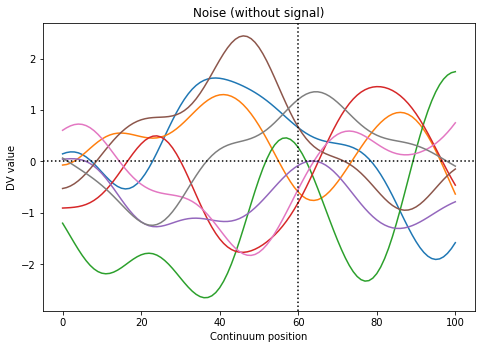

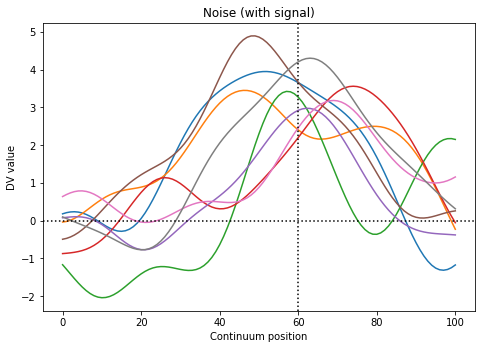

In [3]:
np.random.seed(200)
J     = 8               #sample size
FWHM  = 20              #smoothness
noise = spm1d.rft1d.randn1d(J, Q, FWHM, pad=True) #random 1D residuals
y     = signal + noise  #random sample containing true signal


pyplot.figure()
ax      = pyplot.axes( [0, 0, 1, 1] )
ax.plot( noise.T)
ax.axhline(0, color='k', ls=':')
ax.axvline(q, color='k', ls=':')
ax.set_xlabel('Continuum position')
ax.set_ylabel('DV value')
ax.set_title('Noise (without signal)')
pyplot.show()


pyplot.figure()
ax      = pyplot.axes( [0, 0, 1, 1] )
ax.plot( y.T)
ax.axhline(0, color='k', ls=':')
ax.axvline(q, color='k', ls=':')
ax.set_xlabel('Continuum position')
ax.set_ylabel('DV value')
ax.set_title('Noise (with signal)')
pyplot.show()

___

### Effect of true signal amplitude FDR threshold

Next let's systematically vary the true signal amplitude, compute the t statistic separately for each magnitude, then check the effect on the computed FDR threshold. For simplicity we'll use the same noise each time. We'll also compute the RFT threshold for comparison.

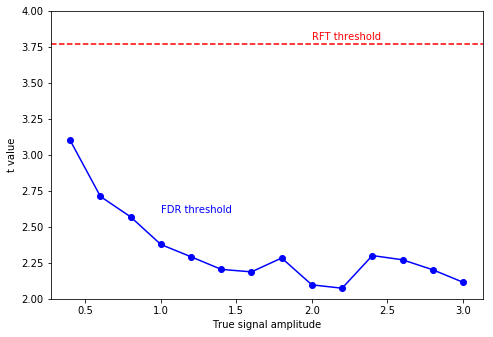

In [4]:
alpha     = 0.05   #Type I error rate
df        = J - 1  #degrees of freedom


amps      = np.linspace(0, 3, 16)
tvalue    = []
thresh    = []
for a in amps:
    y     = (a * signal) + noise
    t     = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )
    tstar = fdr1d.inference(t, df, alpha=alpha, stat='T')
    tvalue.append(t)
    thresh.append(tstar)
    

thresh_rft = spm1d.rft1d.t.isf(alpha, df, Q, FWHM)
    
pyplot.figure()
ax        = pyplot.axes( [0, 0, 1, 1] )
ax.plot(amps, thresh, 'o-', color='b')
ax.axhline(thresh_rft, color='r', ls='--')
ax.text(1, 2.6, 'FDR threshold', color='b')
ax.text(2, 3.8, 'RFT threshold', color='r')
ax.set_ylim(2, 4)
ax.set_xlabel('True signal amplitude')
ax.set_ylabel('t value')
pyplot.show()

We can see the following:

* The FDR threshold decreases as true signal amplitude increases
* The RFT threshold is constant because it depends only on the smoothness of the noise

Plotting the 1D t statistic clarifies why FDR decreases:

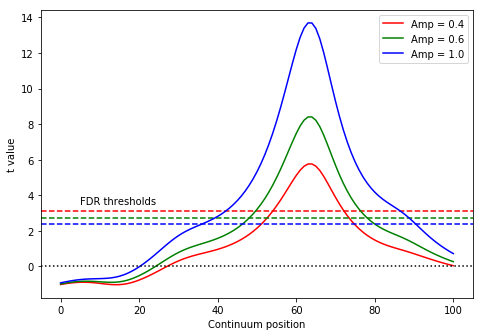

In [5]:
pyplot.figure()
ax        = pyplot.axes( [0, 0, 1, 1] )
colors    = ['r', 'g', 'b']
for i,ind in enumerate([2, 3, 5]):
    ax.plot( tvalue[ind], color=colors[i], label='Amp = %.1f'%amps[ind] )
    ax.axhline( thresh[ind], color=colors[i], ls='--')
ax.text(5, 3.5, 'FDR thresholds', color='k')
ax.axhline(0, color='k', ls=':')
ax.set_xlabel('Continuum position')
ax.set_ylabel('t value')
ax.legend()
pyplot.show()


As the signal amplitude increases, an increasing number of continuum nodes exceed a given threshold. In order to maintain the **proportion of false positive nodes** at $\alpha$=0.05, FDR must reduce the threshold so that roughly 5% of the nodes are part of the noise (and not the signal). In other words, FDR regards a greater number of suprathreshold nodes as better evidence of the existence of a true signal, so adjusts the threshold downward in attempts to capture approximately 95% of the signal.

However, this interpretation is valid only over a large number of experiments. FDR does not aim to yield false positive nodes at a rate of 5% for each 1D t continuum. Instead it aims to yield false positive nodes at a rate of 5% for the **infinite set of 1D t continua**.

Let's run more simulations to check the long-term behavior of the FDR threshold.

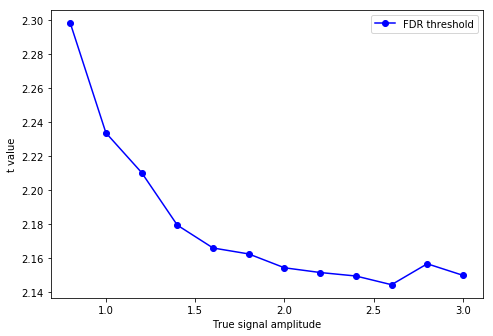

In [6]:
np.random.seed(0)
nIter   = 1000
THRESH  = []

for i in range(nIter):
    thresh  = []
    for a in amps:
        noise = spm1d.rft1d.randn1d(J, Q, FWHM) #random 1D residuals
        y     = (a * signal) + noise
        t     = y.mean(axis=0) / (  y.std(ddof=1, axis=0)/ (J**0.5)  )
        tstar = fdr1d.inference(t, df, alpha=alpha, stat='T')
        if tstar is None:
            tstar = np.nan
        thresh.append( tstar )
    THRESH.append( thresh )


#compute long-term average threshold
THRESH  = np.array(THRESH)
thresh  = THRESH.mean(axis=0)

pyplot.figure()
ax        = pyplot.axes( [0, 0, 1, 1] )
ax.plot(amps, thresh, 'o-', color='b', label='FDR threshold')
ax.set_xlabel('True signal amplitude')
ax.set_ylabel('t value')
ax.legend()
pyplot.show()

We can see that, like the single datasat above, the FDR threshold reduces systematically with signal amplitude over a large number of datasets. However, this threshold reduction over the long term (from about $t$=2.3 to $t$=2.15) is not as pronounced as for the single dataset above (from about $t$=3.1 to $t$=2.15).